# Kmeans motifs

## Kmeans

### Data

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
from katlas.core import *
import pandas as pd, numpy as np,seaborn as sns

In [2]:
# human = pd.read_parquet('raw/human_phosphoproteome.parquet')
# df_grouped = pd.read_parquet('raw/combine_source_grouped.parquet')
human = Data.get_human_site()
ks_dataset = Data.get_ks_dataset()

In [3]:
all_site = pd.concat([human,ks_dataset])

In [4]:
all_site.sub_site.isna().sum()

np.int64(0)

In [5]:
all_site = all_site.drop_duplicates('sub_site')

In [6]:
all_site.shape

(131843, 23)

In [7]:
# all_site = all_site[['sub_site','site_seq']].drop_duplicates('sub_site')

## One-hot encode

In [8]:
from katlas.feature import *

In [9]:
%%time
onehot = onehot_encode_df(all_site,'site_seq')

CPU times: user 2.53 s, sys: 911 ms, total: 3.44 s
Wall time: 3.44 s


In [10]:
onehot.head()

,-20A,-20C,-20D,-20E,-20F,-20G,-20H,-20I,-20K,-20L,...,20R,20S,20T,20V,20W,20Y,20_,20s,20t,20y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Elbow method

In [11]:
all_site.shape

(131843, 23)

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

CPU times: user 23min 20s, sys: 46.3 s, total: 24min 6s
Wall time: 9min 50s


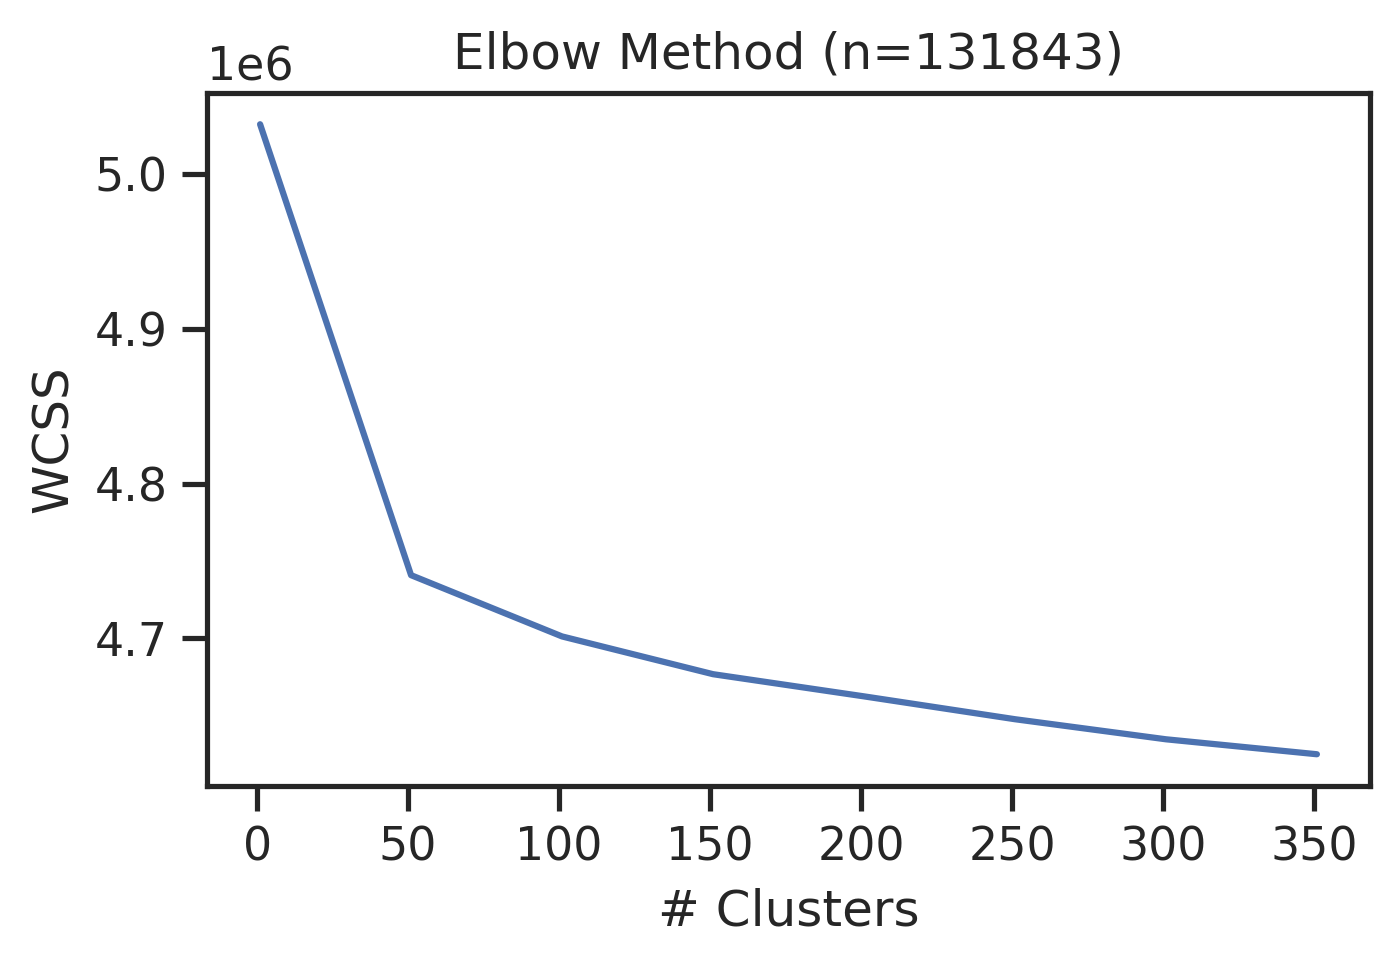

In [ ]:
%%time
get_clusters_elbow(onehot)

### Kmeans

If using RAPIDS

In [14]:
# # pip install --extra-index-url=https://pypi.nvidia.com \"cudf-cu12==25.2.*\" \"cuml-cu12==25.2.*\"

# %load_ext cudf.pandas

# import numpy as np, pandas as pd
# from cuml import KMeans
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# from katlas.core import *
# from katlas.plot import *

In [14]:
def kmeans(onehot,n=2,seed=42):
    kmeans = KMeans(n_clusters=n, random_state=seed,n_init='auto')
    return kmeans.fit_predict(onehot)

In [15]:
ncluster=[50,150,300,500]
seeds=[42,2025,28]

In [16]:
all_site['test_id']=1

In [17]:
get_cluster_pssms(all_site,'test_id')

100%|████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


,-20P,-20G,-20A,-20C,-20S,-20T,-20V,-20I,-20L,-20M,...,20H,20K,20R,20Q,20N,20D,20E,20pS,20pT,20pY
1,0.079841,0.066693,0.07291,0.013331,0.064879,0.040649,0.050503,0.034598,0.081195,0.01958,...,0.021924,0.067816,0.063392,0.047306,0.033401,0.052386,0.079796,0.041843,0.013849,0.00508


In [18]:
%%time
pssms=[]
for seed in seeds:
    print('seed',seed)
    for n in ncluster:
        colname = f'cluster{n}_seed{seed}'
        print(colname)
        all_site[colname] = kmeans(onehot,n=n,seed=seed)
        pssm_df = get_cluster_pssms(all_site,colname,count_thr=0) # count threshold 0, no threshold for non-nan
        pssm_df.index =colname+'_'+pssm_df.index.astype(str)
        pssms.append(pssm_df)

seed 42
cluster50_seed42


100%|██████████████████████████████████████████| 50/50 [00:02<00:00, 17.83it/s]


cluster150_seed42


100%|████████████████████████████████████████| 150/150 [00:04<00:00, 32.45it/s]


cluster300_seed42


100%|████████████████████████████████████████| 300/300 [00:07<00:00, 41.01it/s]


cluster500_seed42


100%|████████████████████████████████████████| 500/500 [00:11<00:00, 44.43it/s]


seed 2025
cluster50_seed2025


100%|██████████████████████████████████████████| 50/50 [00:02<00:00, 17.08it/s]


cluster150_seed2025


100%|████████████████████████████████████████| 150/150 [00:04<00:00, 32.05it/s]


cluster300_seed2025


100%|████████████████████████████████████████| 300/300 [00:08<00:00, 37.39it/s]


cluster500_seed2025


100%|████████████████████████████████████████| 500/500 [00:10<00:00, 46.36it/s]


seed 28
cluster50_seed28


100%|██████████████████████████████████████████| 50/50 [00:02<00:00, 18.25it/s]


cluster150_seed28


100%|████████████████████████████████████████| 150/150 [00:04<00:00, 32.84it/s]


cluster300_seed28


100%|████████████████████████████████████████| 300/300 [00:06<00:00, 43.14it/s]


cluster500_seed28


100%|████████████████████████████████████████| 500/500 [00:10<00:00, 46.35it/s]

CPU times: user 2h 16min 41s, sys: 35.7 s, total: 2h 17min 17s
Wall time: 19min 31s


In [19]:
pssms = pd.concat(pssms,axis=0)

In [20]:
pssms.shape

(3000, 943)

Save:

In [21]:
pssms.to_parquet('raw/kmeans.parquet')
all_site.to_parquet('raw/kmeans_site.parquet',index=False)

In [23]:
pssms.shape

(3000, 943)

## Filter max PSSM value

In [24]:
import pandas as pd
from katlas.pssm import *
from functools import partial

In [25]:
pssms = pd.read_parquet('raw/kmeans.parquet')
all_site=pd.read_parquet('raw/kmeans_site.parquet')

In [26]:
pssms.shape

(3000, 943)

## Hierarchical clustering

### Hierarchical clustering of all pssms

In [28]:
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram

In [29]:
import pandas as pd
from katlas.core import *

In [30]:
# pssms = pd.read_parquet('raw/kmeans.parquet')

In [31]:
Z = get_Z(pssms)

  0%|          | 0/4498500 [00:00<?, ?it/s]

In [40]:
labels= get_pssm_seq_labels(pssms,thr=0.3)

In [42]:
# plot_dendrogram(Z,color_thr=0.05, labels=labels)
# save_pdf('raw/dendrogram.pdf')
# plt.close()

Visualize and find out the color threshold that works. 

After determine the color threshold, use it to cut the tree.

Visualize some logos

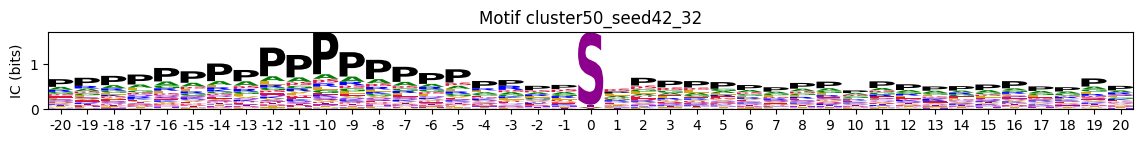

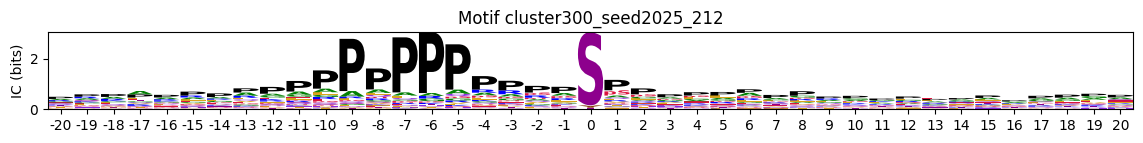

In [43]:
plot_logos_idx(pssms, 'cluster50_seed42_32','cluster300_seed2025_212')

### Cut trees to merge similar pssms

In [141]:
labels = fcluster(Z, t=0.05, criterion='distance')
# pssm_df['cluster'] = labels

In [142]:
len(labels)

3000

In [143]:
np.unique(labels)[:10] # always start from 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

###  Expand the cluster into a single column

In [135]:
id_vars = ['sub_site', 'site_seq']
value_vars = [col for col in all_site.columns if col.startswith('cluster')]

In [136]:
all_site_long = pd.melt(all_site, id_vars=id_vars, value_vars=value_vars, var_name='cluster_info', value_name='cluster')

In [137]:
all_site_long['cluster_id']=all_site_long['cluster_info'] + '_' + all_site_long['cluster'].astype(str)

In [138]:
all_site_long.head()

,sub_site,site_seq,cluster_info,cluster,cluster_id
0,A0A024R4G9_S20,_MTVLEAVLEIQAITGSRLLsMVPGPARPPGSCWDPTQCTR,cluster50_seed42,33,cluster50_seed42_33
1,A0A075B6Q4_S24,QKSENEDDSEWEDVDDEKGDsNDDYDSAGLLsDEDCMSVPG,cluster50_seed42,41,cluster50_seed42_41
2,A0A075B6Q4_S35,EDVDDEKGDsNDDYDSAGLLsDEDCMSVPGKTHRAIADHLF,cluster50_seed42,30,cluster50_seed42_30
3,A0A075B6Q4_S57,EDCMSVPGKTHRAIADHLFWsEETKSRFTEYsMTssVMRRN,cluster50_seed42,30,cluster50_seed42_30
4,A0A075B6Q4_S68,RAIADHLFWsEETKSRFTEYsMTssVMRRNEQLTLHDERFE,cluster50_seed42,11,cluster50_seed42_11


### Map merged cluster

In [144]:
len(labels)

3000

In [145]:
max(labels)

np.int32(1290)

In [146]:
cluster_map = pd.Series(labels,index=pssms.index)

In [147]:
cluster_map.sort_values()

cluster500_seed28_228         1
cluster500_seed42_403         1
cluster150_seed2025_111       2
cluster500_seed2025_76        2
cluster300_seed42_249         3
                           ... 
cluster300_seed28_203      1286
cluster500_seed42_321      1287
cluster500_seed28_458      1288
cluster300_seed42_262      1289
cluster500_seed42_268      1290
Length: 3000, dtype: int32

For those unmapped cluster_ID, we assign them zero value:

In [148]:
# not all cluster_id have a corresponding for new cluster ID, as they could be filtered out
all_site_long['cluster_new'] = all_site_long.cluster_id.map(lambda x: cluster_map.get(x, 0)) #0 is unmapped

In [149]:
all_site_long.shape

(1582116, 6)

In [150]:
all_site_long = all_site_long.drop_duplicates(subset=['cluster_new','sub_site'])

In [151]:
all_site_long.shape

(843252, 6)

In [152]:
all_site_long.to_parquet('raw/kmeans_site_long_cluster_new.parquet',index=False)

### Get new cluster motifs

In [153]:
pssms2 = get_cluster_pssms(all_site_long,
                           'cluster_new')

100%|██████████████████████████████████████| 1290/1290 [00:31<00:00, 40.73it/s]


Note here we didn't put count threshold here, the default is 10

In [154]:
pssms2.shape

(1286, 943)

In [156]:
# pssms2 = pssms2.drop(index=0) # as 0 represents unmapped

## Filter

In [168]:
count_map = all_site_long.cluster_new.value_counts()

In [161]:
idxs = count_map[count_map>40].index

In [162]:
pssms2 = pssms2.loc[idxs]

In [163]:
def get_surrounding_max(r):
    return float(recover_pssm(r).drop(columns=[0]).max().max())

In [164]:
max_val = pssms2.apply(get_surrounding_max,axis=1)
# max_val.hist(bins=50);
pssms2 = pssms2.loc[max_val>=0.4]

In [165]:
pssms2.shape

(1169, 943)

In [166]:
pssms2.to_parquet('out/all_site_pssms_filter.parquet') # the index order is from count high to count low

## Hierarchical clustering of merged pssms

In [167]:
Z2 = get_Z(pssms2)

  0%|          | 0/682696 [00:00<?, ?it/s]

Note that a sub site may have multiple cluster_new ID, so we need to drop duplicates to get correct value counts

In [171]:
labels= get_pssm_seq_labels(pssms2,count_map = count_map , thr=0.3)

In [172]:
labels[:4]

['29 (n=8,243): ....................s*P...................',
 '369 (n=6,453): ....................s*.s..................',
 '1054 (n=6,368): ....................t*P...................',
 '338 (n=6,182): .................R..s*....................']

In [173]:
plot_dendrogram(Z2,labels=labels,color_thr=0.07)
save_pdf('out/dendrogram.pdf')
save_svg('out/human_motif_dendrogram.svg')
plt.close()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

## (Old) Onehot of cluster number

In [125]:
all_site_long['sub_site_seq'] = all_site_long['sub_site']+'_'+all_site_long['site_seq']

In [126]:
all_site_onehot = pd.crosstab(all_site_long['sub_site_seq'], all_site_long['cluster_new'])

In [127]:
# greater than 0 to be True and convert to int
all_site_onehot = all_site_onehot.gt(0).astype(int)

In [128]:
all_site_onehot.max()

cluster_new
1       1
2       1
3       1
4       1
5       1
       ..
1286    1
1287    1
1288    1
1289    1
1290    1
Length: 1290, dtype: int64

In [131]:
# remove 0 as it is unassigned for cut tree
# all_site_onehot = all_site_onehot.drop(columns=0)

In [ ]:
all_site_onehot.sum().sort_values()

In [ ]:
# for save in parquet, needs column type to be str
all_site_onehot.columns = all_site_onehot.columns.astype(str)

In [ ]:
all_site_onehot.to_parquet('out/all_site_cluster_onehot.parquet')

In [ ]:
# all_site_onehot=pd.read_parquet('out/all_site_cluster_onehot.parquet')

In [ ]:
all_site_onehot.reset_index()